In [5]:
# import Pkg; Pkg.add("DataFrames")
using KrylovKit
include("ed.jl")

main2 (generic function with 1 method)

# Perturbation theory vs Mathieu function

For this analysis, consider the Hamiltonian
$$H=-\frac{\partial^2}{\partial \phi^2} + g\cos \phi$$
$$\tilde{H}=\cos \phi-\frac{1}{g}\frac{\partial^2}{\partial \phi^2}$$
The eigenvalue equation for this is
$$\cos \phi \psi-\frac{1}{g}\frac{\partial^2 \psi}{\partial \phi^2}=\tilde{E}\psi=\frac{E}{g}\psi$$
$$\frac{\partial^2 \psi}{\partial \phi^2}+g(\tilde{E}-\cos\phi)\psi=0$$
This is in the form of the Mathieu equation where $q=g/2$ and $a=g\tilde{E}=E$

In [115]:
using MathieuFunctions
using Plots

function interleave(a::Vector{T}, b::Vector{T}) where T
    length(a) == length(b) || error("length mismatch")
    c = Vector{T}(undef, 2*length(a))
    i = 0
    for (x, y) in zip(a, b)
        c[i += 1] = x
        c[i += 1] = y
    end
    return c
end
# f(q) = charA(q;k=0:10) 
f(q) = interleave(charA(q;k=0:10), charB(q;k=1:11))
k_values = []
g_values = 10 .^(0:0.1:9)
for g in g_values
    # println(collect(Iterators.flatten(f(g/2)))[1]/g+1)
    eigenvalue = Complex(collect(Iterators.flatten(f(g/2)))[1]+ g)
    # println(1/2* (-1 + 1/(3^(1/3) *(54* eigenvalue + sqrt(-3 + 2916* eigenvalue^2))^(1/3)) + (54 *eigenvalue + sqrt(-3 + 2916* eigenvalue^2))^(1/3)/3^(2/3)))
    push!(k_values, real(1/2* (-1 + 1/(3^(1/3) *(54* eigenvalue + sqrt(-3 + 2916* eigenvalue^2))^(1/3)) + (54 *eigenvalue + sqrt(-3 + 2916* eigenvalue^2))^(1/3)/3^(2/3))))
end

plot(g_values, k_values, xlabel="g", ylabel="k", dpi=300)

# k=13
# eigenvalues_pt = -1 + 1/(3g)*k*(k+1)*(2k+1)
# println(eigenvalues, " ", eigenvalues_pt)
savefig("tmp.png")

"c:\\Users\\jonat\\OneDrive\\Documents\\programming\\AnacondaProjects\\PHYS437B\\dmrg\\ed\\tmp.png"

In [242]:
g = 1e8
println(f(g*2)[1]/4/g)
# -10000 + 5*(5+1)/3

-0.9999292899468869


# Hessian diagonalization

In [191]:
Nsites = 2
angle = 0
Estrength = 0
g = 10000


10000

In [192]:
using Symbolics
using LinearAlgebra
using IterTools

# numerically diagonalize hamiltonian
@variables x[1:Nsites]
hamiltonian = g*sum(sin(ϕ_1)*sin(ϕ_2) - 2*cos(ϕ_1)*cos(ϕ_2) for (ϕ_1, ϕ_2) in partition(x,2,1))
# hamiltonian = g*sum(ϕ_1*ϕ_2+ϕ_1^2+ϕ_2^2 -2 for (ϕ_1, ϕ_2) in partition(x,2,1))
ground_energy = substitute(hamiltonian, Dict(y => 0 for y in x)).val
a = substitute(Symbolics.hessian(hamiltonian,[x...]), Dict(y => π for y in x))
a = map(x-> x.val, a)

λ, vecs = eigen(a)

eigenvalues2 = []
for n in Tuple.(CartesianIndices(Tuple(0:7 for i=1:Nsites)))
    # vec = (n .+ 1/2) .* sqrt.(2*λ)  .+ ground_energy/Nsites
    # push!(eigenvalues2,\(A, vec)[end])
    push!(eigenvalues2,sum((n .+ 1/2) .* sqrt.(2*λ)) + ground_energy)
end
sort(eigenvalues2)[1:10]

10-element Vector{Any}:
 -19806.814834742185
 -19665.393478504877
 -19561.86586046387
 -19523.97212226757
 -19420.444504226558
 -19382.550766030257
 -19316.91688618555
 -19279.02314798925
 -19241.12940979295
 -19175.495529948243

# Mathieu functions

In [1]:
# comparing the N=2 case with the Mathieu functions
using MathieuFunctions

function interleave(a::Vector{T}, b::Vector{T}) where T
    length(a) == length(b) || error("length mismatch")
    c = Vector{T}(undef, 2*length(a))
    i = 0
    for (x, y) in zip(a, b)
        c[i += 1] = x
        c[i += 1] = y
    end
    return c
end
# f(q) = charA(q;k=0:10) 
f(q) = interleave(charA(q;k=0:10), charB(q;k=1:11))
h(q) = interleave(charA(q;k=0:10)[1:2:end], charB(q;k=2:12)[1:2:end])
# println(h(g))
g = 0
sort(collect(Iterators.flatten((f(g/2) .+ h(3/2*g)') ./ 2)))


264-element Vector{Float64}:
   0.0
   0.5
   0.5
   2.0
   2.0
   2.0
   2.0
   2.5
   2.5
   2.5
   ⋮
 104.0
 104.0
 110.5
 110.5
 112.5
 112.5
 122.0
 122.0
 132.5

In [1]:
import Pkg
Pkg.rm("PyPlot")

    Updating `C:\Users\jonat\OneDrive\Documents\programming\AnacondaProjects\PHYS437B\dmrg\Project.toml`
  [d330b81b] - PyPlot v2.11.2
    Updating `C:\Users\jonat\OneDrive\Documents\programming\AnacondaProjects\PHYS437B\dmrg\Manifest.toml`
  [8f4d0f93] - Conda v1.10.0
  [438e738f] - PyCall v1.96.4
  [d330b81b] - PyPlot v2.11.2
  [81def892] - VersionParsing v1.3.0


In [4]:
using LaTeXStrings
using Plots

pyplot()
function filter_checkerboard(x)
    xlen, ylen = size(x)
    output = zeros(xlen*ylen ÷ 2)
    k = 1
    for i=1:xlen
        for j=1:ylen
            if (i÷2 + (j÷2))%2 == 0
                # println(i," ",j)
                output[k] = x[i,j]
                k += 1
            end
        end
    end 
    return output
end

# ENV["GKS_FONT_DIRS"] = pwd()
# using GR
# font = loadfont("times.ttf")
# settextfontprec(font, GR.TEXT_PRECISION_OUTLINE)

PyPlot.matplotlib[:rc]("text", usetex=true)
p = plot(xlabel=L"$g$", ylabel=L"E", legend=nothing, fontfamily="times", dpi=300)
g_values =0:0.01:30
data = reduce(vcat,transpose.([collect(Iterators.flatten(filter_checkerboard(f(g/2) .+ f(3/2*g)') ./2)) for g in g_values]))
data = data[:, sortperm(data[1,:])]
for i in 1:20
    plot!(p, g_values, data[:,i])
end
display(p)
savefig("2024_06_13_mathieu_N=2_ed.png")

# DVR

In [20]:
mmax = 4
Nsites = 2
angle = 0
Estrength = 0
g = 100
pairs = "nearest"
energies = 20

dimension_parity = "even"
if dimension_parity  == "even"
    dim = 2*mmax
else
    dim = 2*mmax+1
end
initial_state = rand(ComplexF64, Int(2*mmax+1)^Nsites)
H(x) = Hamiltonian_DVR(x; Nsites=Nsites, mmax=mmax, g=g, angle=angle, Estrength=Estrength, pairs=pairs, dimension_parity=dimension_parity)
memory = @allocated(tmp = KrylovKit.eigsolve(H, initial_state, energies, :SR))
vals, vecs, info = tmp

real.(vecs)

20-element Vector{Vector{Float64}}:
 [-0.5494755621413638, -0.031216215087773922, 0.0020904101387019766, -0.0007325838317706518, 0.0011426378208770384, -0.0007325838317708488, 0.0020904101387020004, -0.031216215087770446, -0.031216215087770866, -0.0013556209093994697  …  -1.1563913793320396e-17, -1.4506089117139366e-16, -1.5845199229079236e-16, -1.2620146552770536e-16, -9.581781027101412e-17, -8.256601602323309e-17, -3.855554541203126e-17, -3.306543605236272e-17, -2.776201010507068e-17, -8.786042611627818e-17]
 [0.5317878978787269, 0.030228172157780973, -0.002034320679823266, 0.0007860747902040494, 4.562944630360313e-12, 0.0007860747902039004, -0.0020343206798232997, 0.0302281721577852, 0.030228172157784436, 0.0013040741123174328  …  -2.8716841062317273e-17, -8.866312633942798e-17, -1.0621395324337583e-16, -6.851606647691148e-17, -8.61134368596363e-17, -4.6935613720810266e-17, -4.579666856679882e-17, -4.378900768778556e-17, -2.0347796960644292e-17, -6.99495623155728e-17]
 [3.9142869835

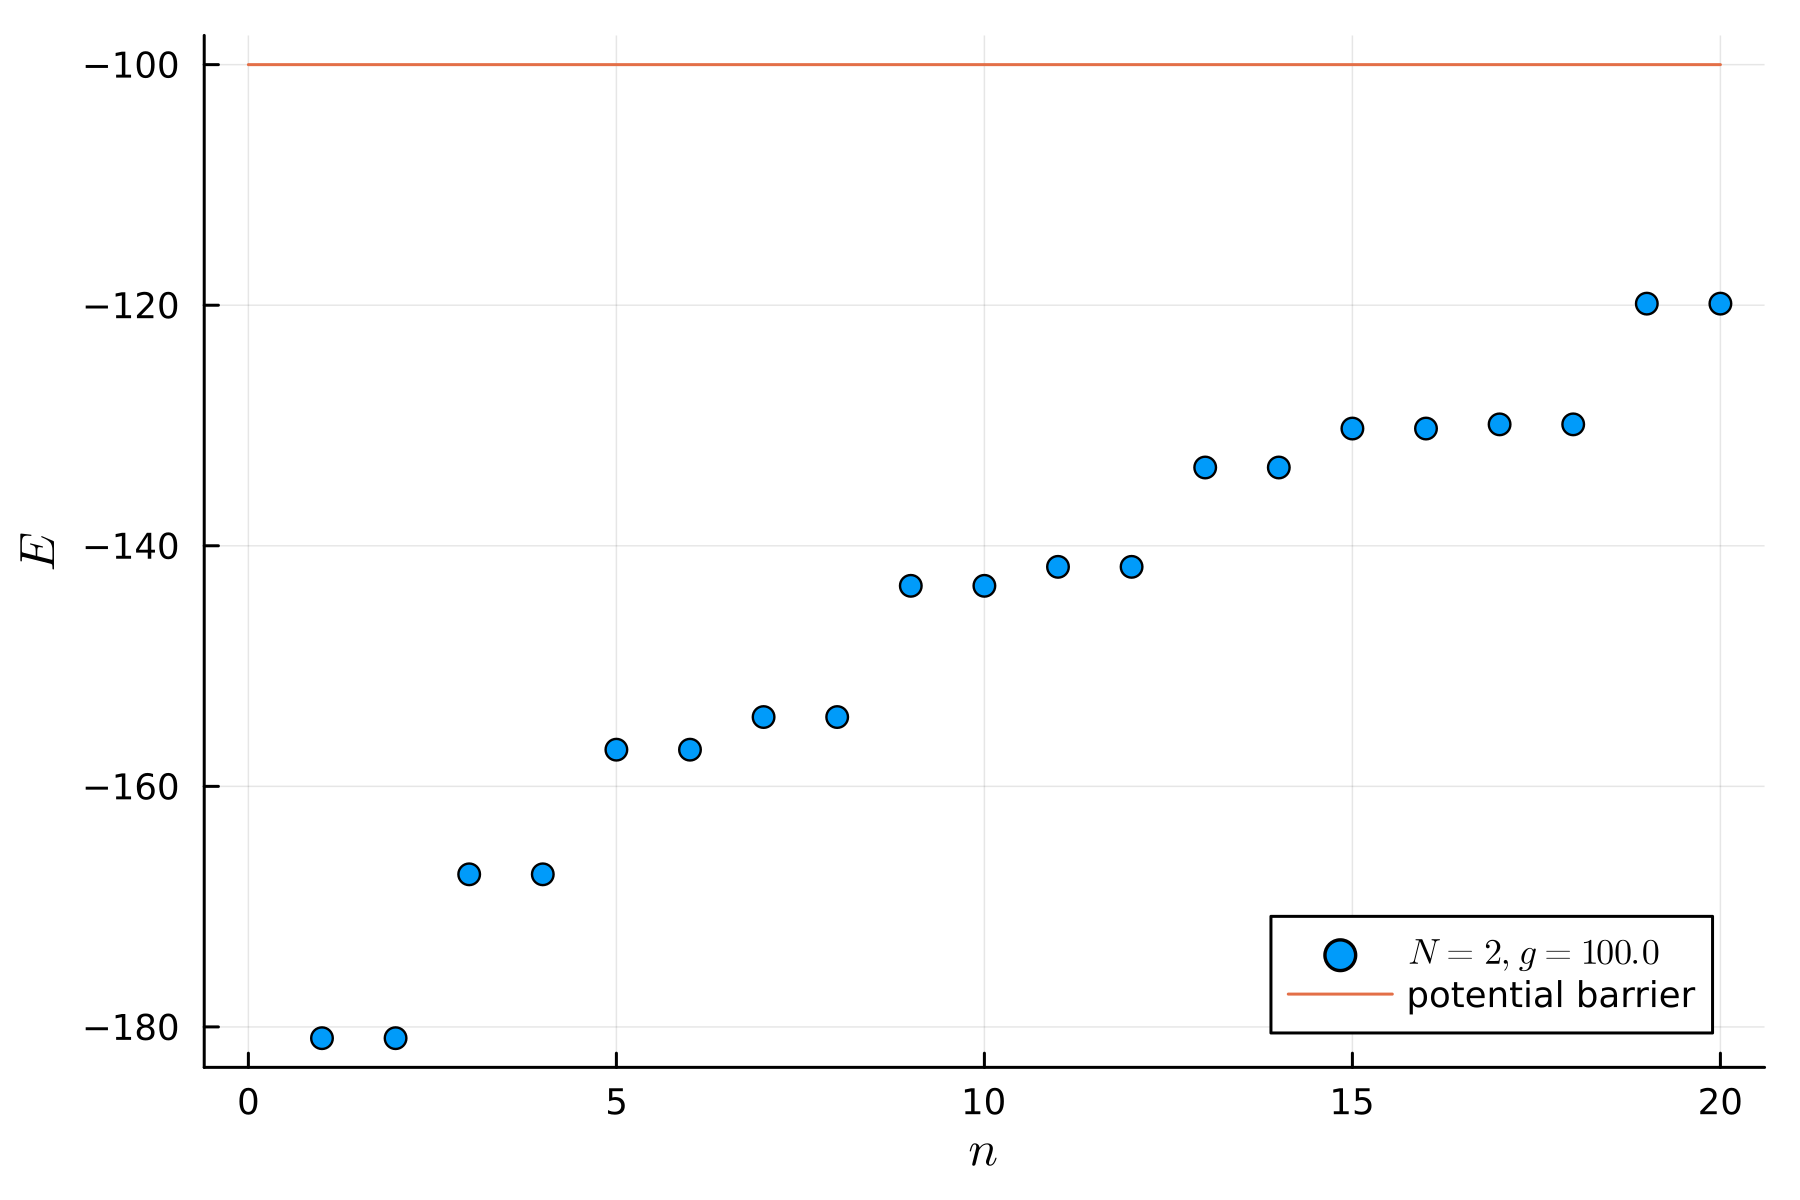

In [119]:
using Plots
using LaTeXStrings
using Printf: Format, format

p = scatter(real.(vals), xlabel=L"n", ylabel=L"E", label=format(Format(L"N=%d, g=%0.1f"), Nsites, g), dpi=300)
plot!(p, [0,20],[-g,-g], label="potential barrier")
# savefig(p, "2024_06_05_DVR_energy_levels_N=2.pdf")
display(p)

In [21]:
# inversion_projection_dvr(vecs[energy_level]; Nsites, mmax, parity="odd", direction="LR")
energy_level = 1
indices = sortperm(abs.(vecs[energy_level]))
p = (abs.(vecs[energy_level]).^2)[indices]
for i=0:20
    data = fill(0, Nsites)
    inserted_data = digits(indices[end - i]-1, base=dim)
    # println(inserted_data)
    data[1: length(inserted_data)] += inserted_data
    println(data/dim*360, " ", abs.(vecs[energy_level][indices][end-i])^2, " ")
end



[0.0, 0.0] 0.49353227492095747 
[180.0, 180.0] 0.4935322668631656 
[45.0, 0.0] 0.0015928661526282964 
[0.0, 315.0] 0.0015928661526281695 
[0.0, 45.0] 0.001592866152627958 
[315.0, 0.0] 0.0015928661526278998 
[225.0, 180.0] 0.0015928661266072822 
[180.0, 135.0] 0.0015928661266072536 
[135.0, 180.0] 0.0015928661266072152 
[180.0, 225.0] 0.0015928661266071949 
[45.0, 315.0] 2.7818367427337854e-5 
[315.0, 45.0] 2.781836742720505e-5 
[225.0, 135.0] 2.781836697565107e-5 
[135.0, 225.0] 2.7818366975623216e-5 
[0.0, 90.0] 7.143018931508307e-6 
[90.0, 0.0] 7.1430189315082005e-6 
[0.0, 270.0] 7.143018931508189e-6 
[270.0, 0.0] 7.143018931508043e-6 
[180.0, 90.0] 7.143018814240373e-6 
[180.0, 270.0] 7.143018814240254e-6 
[90.0, 180.0] 7.143018814240034e-6 


In [196]:
hist_data = zeros(Int(2*mmax+1), Nsites, energies)
for energy_level=1:energies
    indices = sortperm(abs.(vecs[energy_level]))
    p = (abs.(vecs[energy_level]).^2)[indices]

    for i in 0:length(indices)-1
        data = fill(1, Nsites)
        inserted_data = digits(indices[end - i]-1, base=Int(2*mmax+1))
        data[end-length(inserted_data)+1:end] += inserted_data
        for (k, d) in enumerate(data)
            hist_data[d,k, energy_level] += p[end - i]
        end
        # println(hist_data)
    end
end
# bitstring(UInt16()

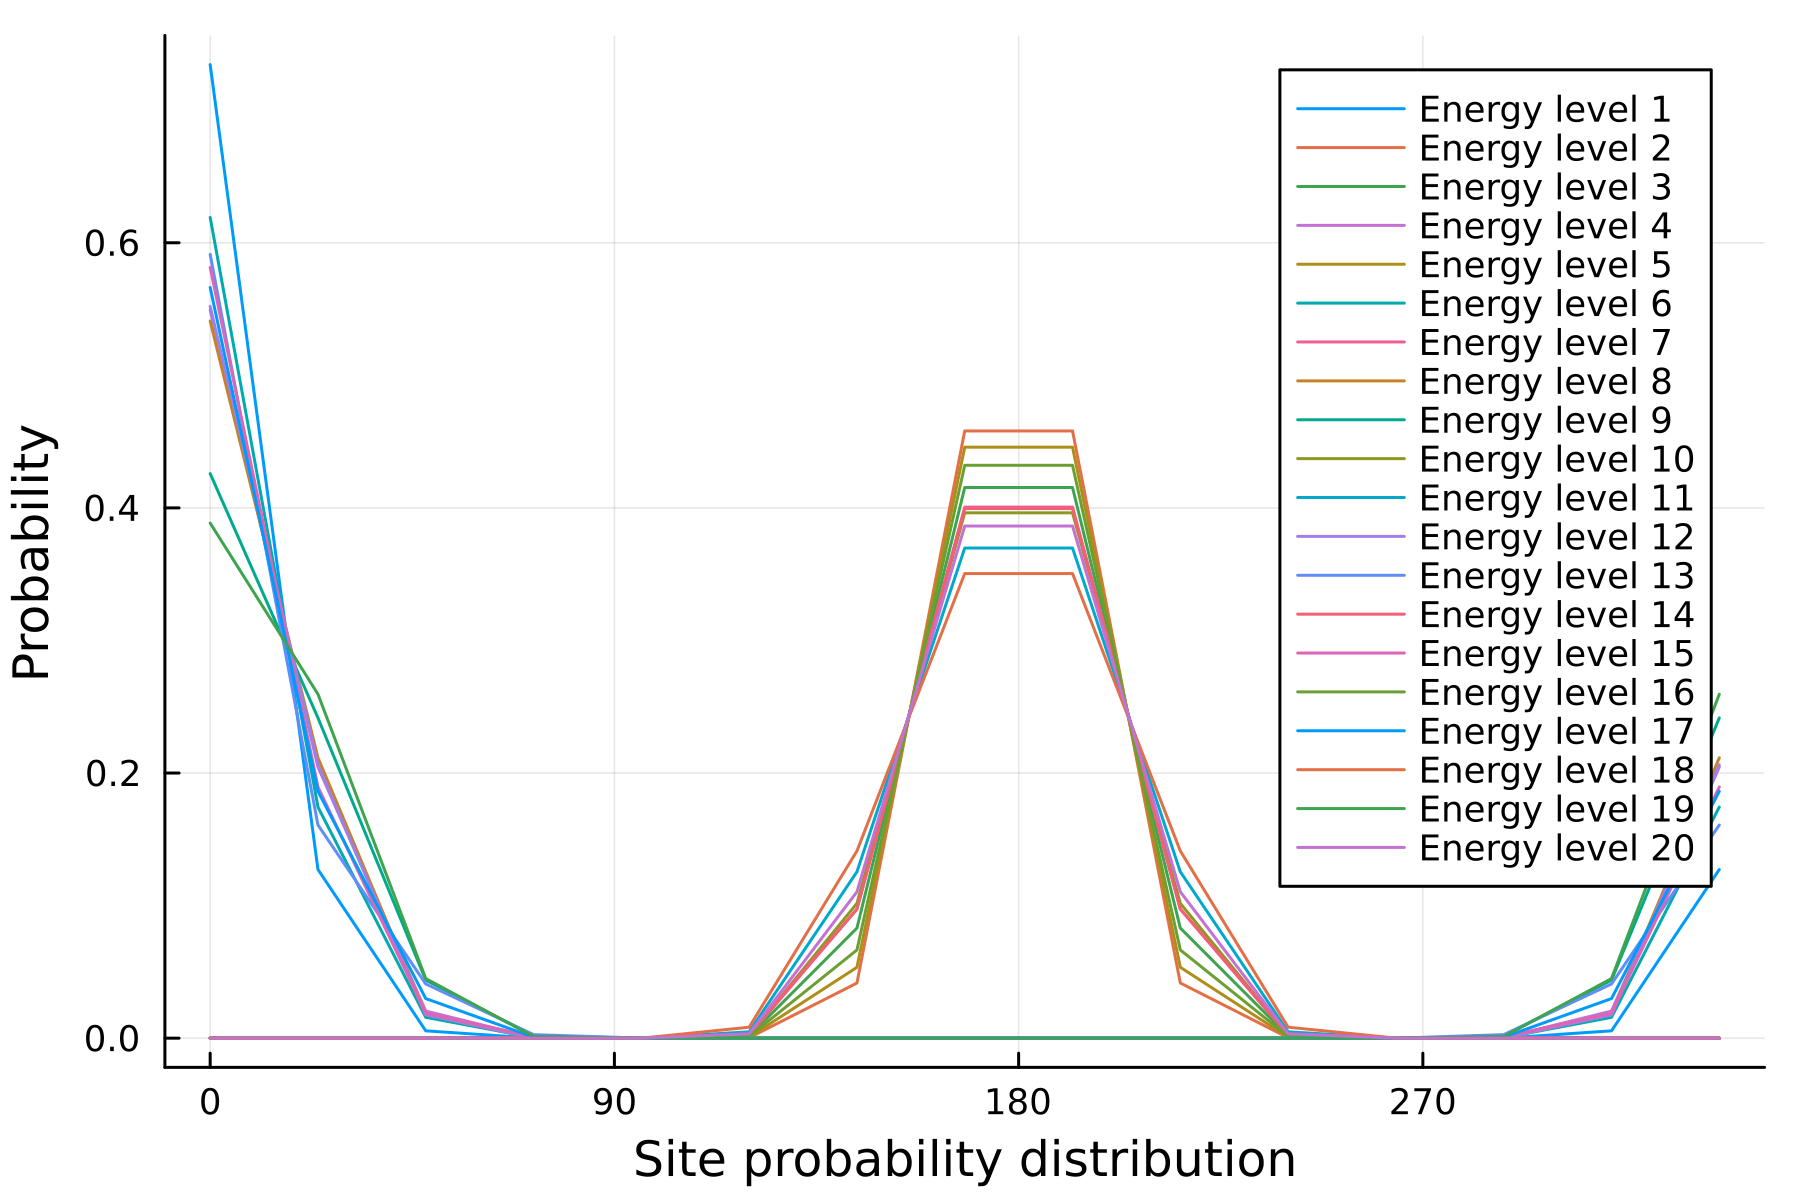

"c:\\Users\\jonat\\OneDrive\\Documents\\programming\\AnacondaProjects\\PHYS437B\\dmrg\\ed\\2024_05_31_single_site2_4_probability_DVR_dist_g=30_mmax=7.png"

In [177]:
using Plots

# data = hist_data[:,:,1]
p = plot(ylabel="Probability", xlabel="Site probability distribution",dpi=300, xticks=([0,90,180,270,360]))
for (i,energy_level) in enumerate(1:20)
    data = hist_data[:,2,energy_level]
    # bar!(p,float(0:length(data)-1) ./length(data) .* 360, reshape(data, length(data)), #alpha=0.6, 
    # label=string("Energy level ", energy_level), bar_width = 360/length(data))
    plot!(p,float(0:length(data)-1) ./length(data) .* 360, reshape(data, length(data)), #alpha=0.6, 
        label=string("Energy level ", energy_level))
end
display(p)
savefig("2024_05_31_single_site2_4_probability_DVR_dist_g=30_mmax=7.png")

In [197]:
using Printf

for (i,(vec, energy)) in enumerate(zip(vecs, vals))
    even_reflection = Int(round(sum(abs.(reflection_projection(vec; Nsites, mmax, parity="even").^2))))
    even_inversion_dvr = Int(round(sum(abs.(inversion_projection_dvr(vec; Nsites, mmax, parity="even").^2))))
    println(@sprintf("%d - energy: %0.3f - inversion_dvr (even): %d - reflection (even): %d", i, real(energy), even_inversion_dvr, even_reflection))
end

1 - energy: -2.222 - inversion_dvr (even): 1 - reflection (even): 1
2 - energy: -2.172 - inversion_dvr (even): 1 - reflection (even): 1
3 - energy: -1.079 - inversion_dvr (even): 0 - reflection (even): 0
4 - energy: -0.805 - inversion_dvr (even): 0 - reflection (even): 0
5 - energy: -0.762 - inversion_dvr (even): 0 - reflection (even): 1
6 - energy: -0.666 - inversion_dvr (even): 0 - reflection (even): 1
7 - energy: -0.527 - inversion_dvr (even): 1 - reflection (even): 1
8 - energy: -0.411 - inversion_dvr (even): 1 - reflection (even): 0
9 - energy: -0.126 - inversion_dvr (even): 0 - reflection (even): 0
10 - energy: 0.051 - inversion_dvr (even): 0 - reflection (even): 0
11 - energy: 0.182 - inversion_dvr (even): 1 - reflection (even): 0
12 - energy: 0.228 - inversion_dvr (even): 1 - reflection (even): 1
13 - energy: 0.230 - inversion_dvr (even): 1 - reflection (even): 1
14 - energy: 0.341 - inversion_dvr (even): 0 - reflection (even): 1
15 - energy: 0.383 - inversion_dvr (even): 0 - r

# M basis

In [202]:
mmax = 7
Nsites = 2
angle = 0
Estrength = 0

pairs = "nearest"
energies = 6

g = 100000
initial_state = rand(ComplexF64, (2*mmax+1)^Nsites)
H(x) = Hamiltonian(x; Nsites=Nsites, mmax=mmax, g=g, angle=angle, Estrength=Estrength, pairs=pairs)
memory = @allocated(tmp = KrylovKit.eigsolve(H, initial_state, energies, :SR))
vals, vecs, info = tmp
real.(vals)

8-element Vector{Float64}:
 -192787.24346622278
 -192780.55013047296
 -184948.49693336006
 -184948.4948402529
 -179558.00689099877
 -179508.65991979014
 -176600.64559749197
 -176587.39203528874

In [193]:
using Printf

for (i,(vec, energy)) in enumerate(zip(vecs, vals))
    even_inversion = Int(round(sum(abs.(inversion_projection_m(vec; Nsites, mmax, parity="even").^2))))
    even_reflection = Int(round(sum(abs.(reflection_projection(vec; Nsites, mmax, parity="even").^2))))
    even_parity = Int(round(sum(abs.(parity_projection_m(vec; Nsites, mmax, parity="even").^2))))
    println(@sprintf("%d - energy: %0.3f - inversion (even): %d - reflection (even): %d - parity (even): %d", i, real(energy), even_inversion, even_reflection, even_parity))
end

1 - energy: -2.222 - inversion (even): 1 - reflection (even): 1 - parity (even): 1
2 - energy: -2.172 - inversion (even): 1 - reflection (even): 1 - parity (even): 0
3 - energy: -1.079 - inversion (even): 0 - reflection (even): 0 - parity (even): 0
4 - energy: -0.805 - inversion (even): 0 - reflection (even): 0 - parity (even): 1
5 - energy: -0.762 - inversion (even): 0 - reflection (even): 1 - parity (even): 0
6 - energy: -0.666 - inversion (even): 0 - reflection (even): 1 - parity (even): 1
7 - energy: -0.527 - inversion (even): 1 - reflection (even): 1 - parity (even): 1
8 - energy: -0.411 - inversion (even): 1 - reflection (even): 0 - parity (even): 0
9 - energy: -0.126 - inversion (even): 0 - reflection (even): 0 - parity (even): 0
10 - energy: 0.051 - inversion (even): 0 - reflection (even): 0 - parity (even): 1
11 - energy: 0.182 - inversion (even): 1 - reflection (even): 0 - parity (even): 1
12 - energy: 0.228 - inversion (even): 1 - reflection (even): 1 - parity (even): 0
13 -

In [180]:
energy_level = 1
indices = sortperm(abs.(vecs[energy_level]))
p = (abs.(vecs[energy_level]).^2)[indices]
for i=0:20
    data = fill(-mmax, Nsites)
    inserted_data = digits(indices[end - i]-1, base=2*mmax+1)
    data[end-length(inserted_data)+1:end] += inserted_data
    println(data, " ", p[end-i])
end


[0, 0, 0, 0] 0.3197760301828279
[0, 1, 1, 0] 0.049163108406419055
[0, -1, -1, 0] 0.04916310840641618
[0, 0, -1, -1] 0.0425511951671602
[-1, -1, 0, 0] 0.042551195167159744
[1, 1, 0, 0] 0.042551195167158745
[0, 0, 1, 1] 0.04255119516715746
[-1, 0, 1, 0] 0.022052957370812577
[0, 1, 0, -1] 0.022052957370812188
[1, 0, -1, 0] 0.02205295737081009
[0, -1, 0, 1] 0.022052957370809322
[0, -1, 1, 0] 0.02080783474688028
[0, 1, -1, 0] 0.0208078347468767
[0, -1, 0, -1] 0.01533567629425792
[1, 0, 1, 0] 0.015335676294257545
[-1, 0, -1, 0] 0.015335676294254998
[0, 1, 0, 1] 0.015335676294254088
[0, 0, 1, -1] 0.014047690021195583
[1, -1, 0, 0] 0.014047690021195044
[-1, 1, 0, 0] 0.014047690021194563
[0, 0, -1, 1] 0.0140476900211931


In [181]:
hist_data = zeros(Int(2*mmax+1), Nsites, energies)
for energy_level=1:energies
    indices = sortperm(abs.(vecs[energy_level]))
    p = (abs.(vecs[energy_level]).^2)[indices]

    for i in 0:length(indices)-1
        data = fill(1, Nsites)
        inserted_data = digits(indices[end - i]-1, base=Int(2*mmax+1))
        data[end-length(inserted_data)+1:end] += inserted_data
        for (k, d) in enumerate(data)
            hist_data[d,k, energy_level] += p[end - i]
        end
        # println(hist_data)
    end
end
# bitstring(UInt16()

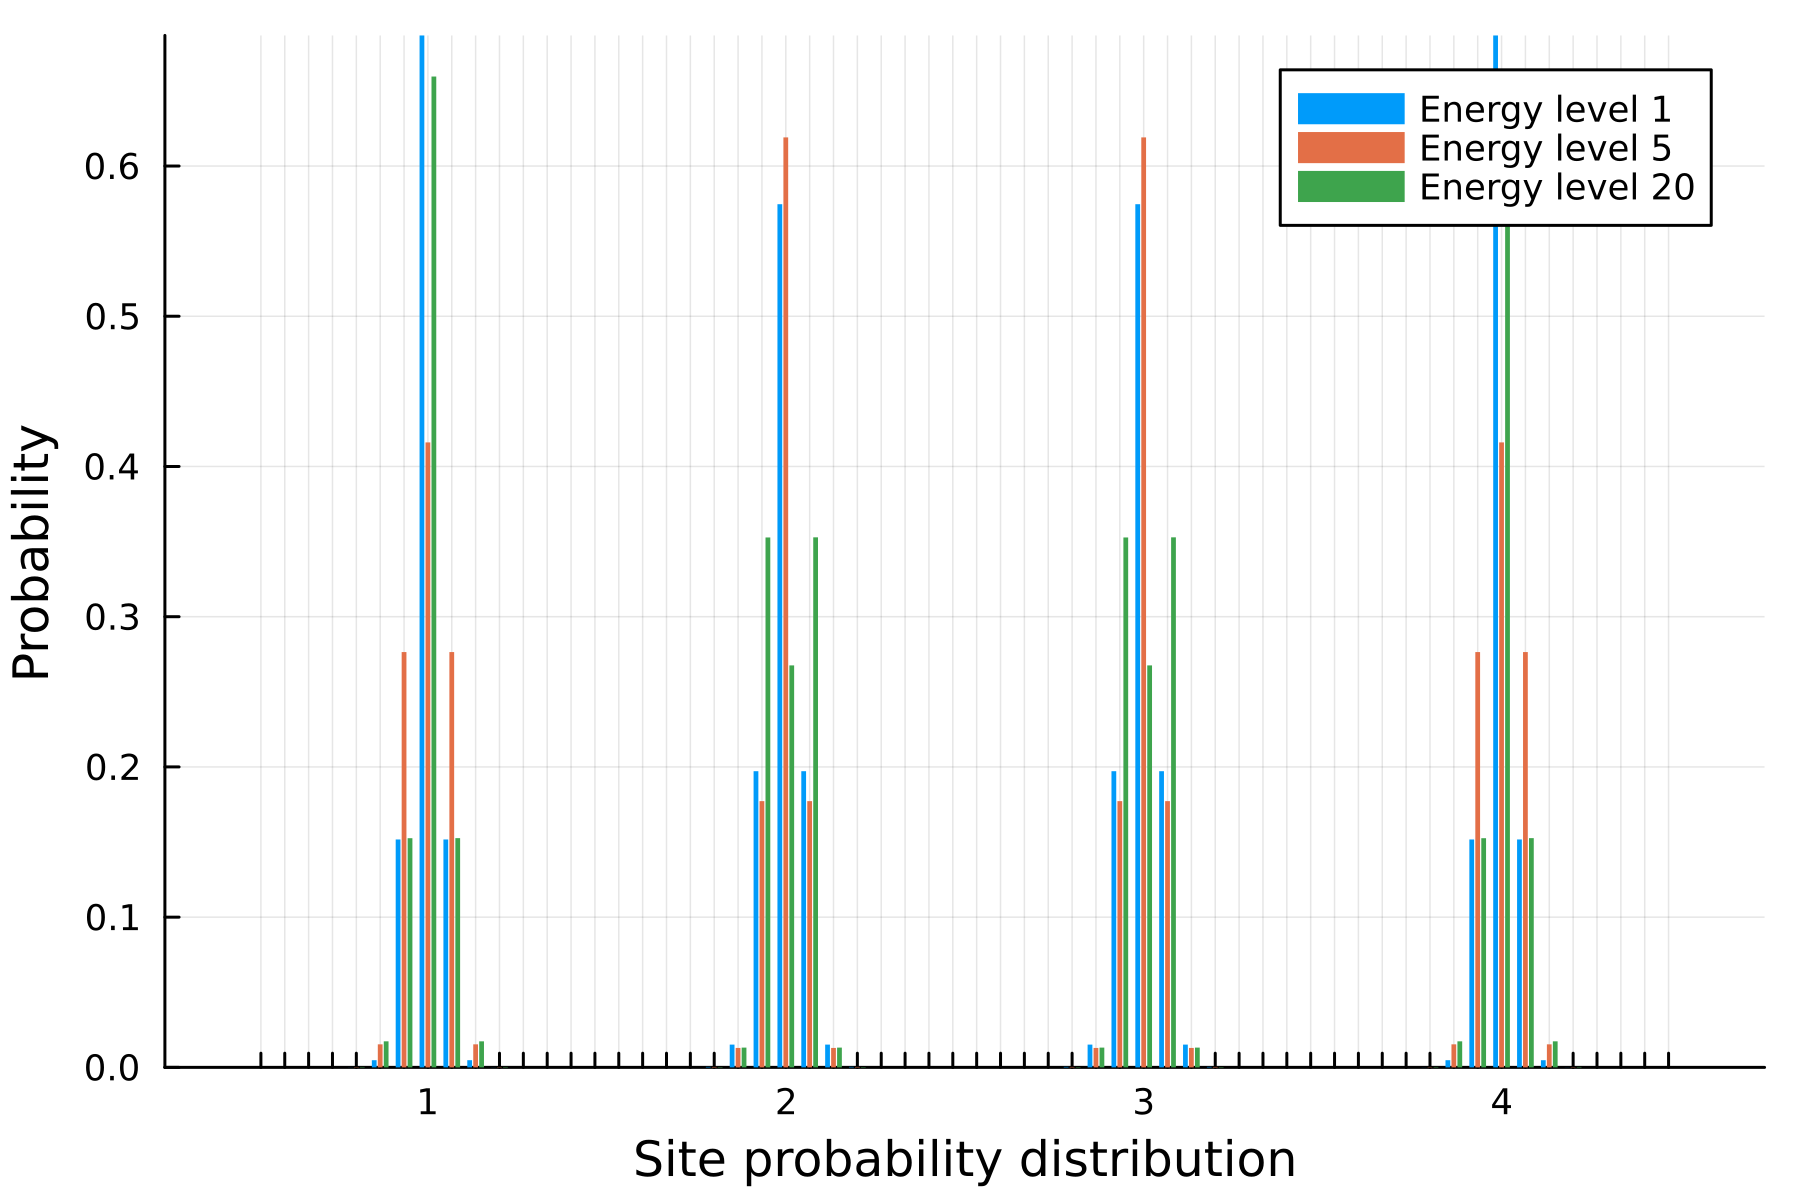

In [182]:
using Plots

data = hist_data[:,:,1]
p = plot(ylabel="Probability", xlabel="Site probability distribution",
xticks=(1:length(data),[(i-mmax-1)%(2*mmax+1)==0 ? (i ÷ (2*mmax+1))+1 : "" for i=1:length(data)]),dpi=300)
for (i,energy_level) in enumerate([1,5,20])
    data = hist_data[:,:,energy_level]
    bar!(p,float(1:length(data)) .+ (i-2)/4, reshape(data, length(data)), #alpha=0.6, 
    label=string("Energy level ", energy_level), bar_width = 0.2, linecolor=nothing)
end
display(p)
# savefig("2024_05_29_single_site_probability_dist_g=100.png")